In [63]:
#Importing the dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

In [64]:
# load the csv data to a pandas dataframe
df = pd.read_csv("/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.drop(columns=['customerID'], inplace=True)
df['TotalCharges'] = df['TotalCharges'].replace(" ", "0.0").astype(float)

In [65]:
print("Columns in dataframe:", df.columns.tolist())
assert 'Churn' in df.columns, "'Churn' column not found! Check data loading or spelling."

Columns in dataframe: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [66]:
# Display shape, columns, and info
display(df.shape)
display(df.columns)
display(df.head(2))
pd.set_option("display.max_columns", None)
display(df.info())

(7043, 20)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


None

In [67]:
# Unique values and nulls
for col in df.columns:
    print(f"{col}: {df[col].unique() if df[col].dtype == 'object' else 'Numerical'}")
    print("-" * 50)
print(df.isnull().sum())

gender: ['Female' 'Male']
--------------------------------------------------
SeniorCitizen: Numerical
--------------------------------------------------
Partner: ['Yes' 'No']
--------------------------------------------------
Dependents: ['No' 'Yes']
--------------------------------------------------
tenure: Numerical
--------------------------------------------------
PhoneService: ['No' 'Yes']
--------------------------------------------------
MultipleLines: ['No phone service' 'No' 'Yes']
--------------------------------------------------
InternetService: ['DSL' 'Fiber optic' 'No']
--------------------------------------------------
OnlineSecurity: ['No' 'Yes' 'No internet service']
--------------------------------------------------
OnlineBackup: ['Yes' 'No' 'No internet service']
--------------------------------------------------
DeviceProtection: ['No' 'Yes' 'No internet service']
--------------------------------------------------
TechSupport: ['No' 'Yes' 'No internet service']
----

In [68]:
# Target Distribution
print(df['Churn'].value_counts())

Churn
No     5174
Yes    1869
Name: count, dtype: int64


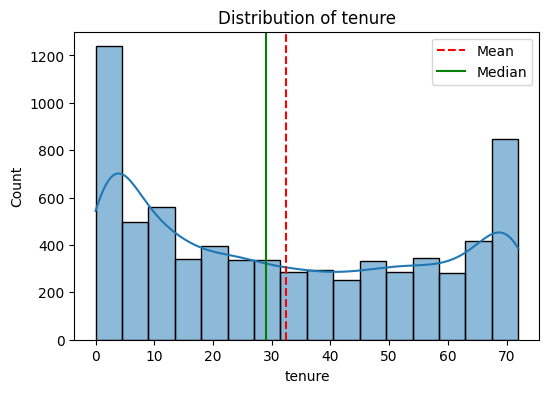

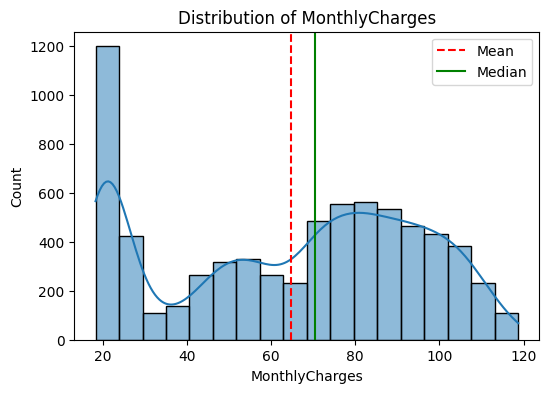

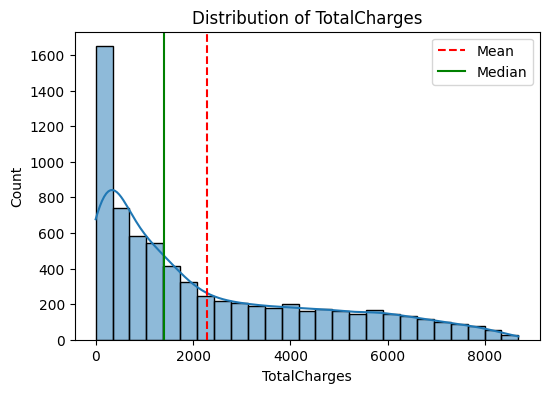

In [69]:
# EDA - Numerical Feature Distribution
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

for feature in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[feature], kde=True)
    plt.axvline(df[feature].mean(), color='r', linestyle='--', label='Mean')
    plt.axvline(df[feature].median(), color='g', linestyle='-', label='Median')
    plt.title(f"Distribution of {feature}")
    plt.legend()
    plt.show()

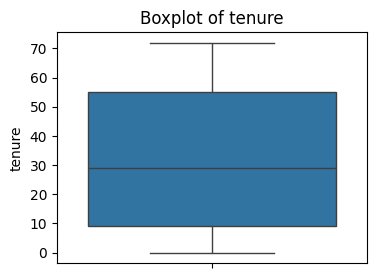

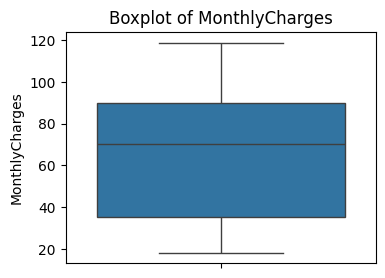

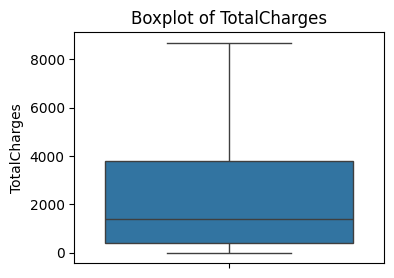

In [70]:
# Box Plots
for feature in numerical_features:
    plt.figure(figsize=(4, 3))
    sns.boxplot(y=df[feature])
    plt.title(f"Boxplot of {feature}")
    plt.show()


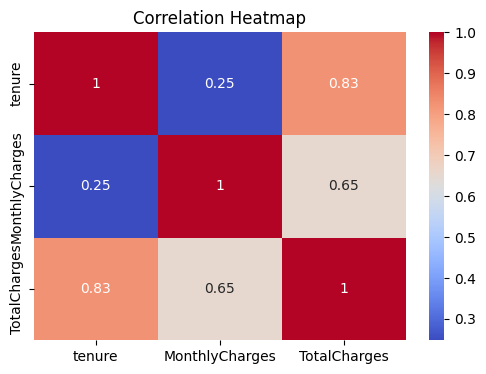

In [71]:
# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

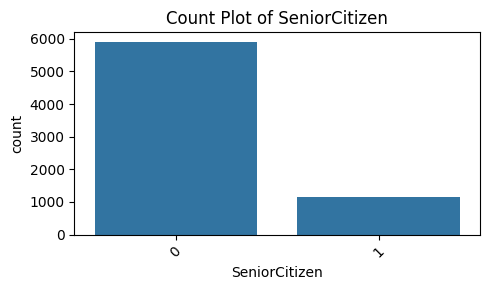

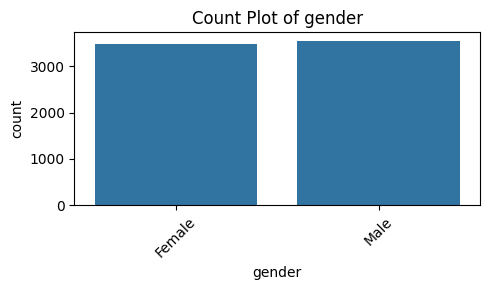

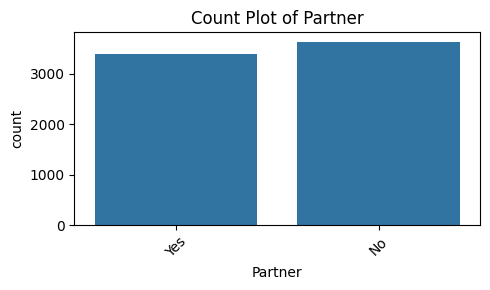

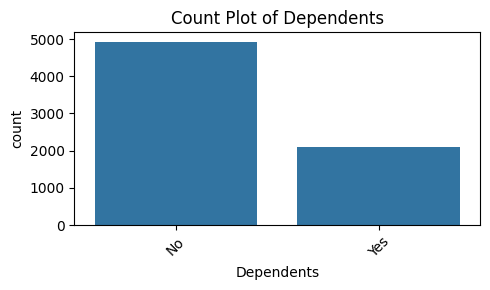

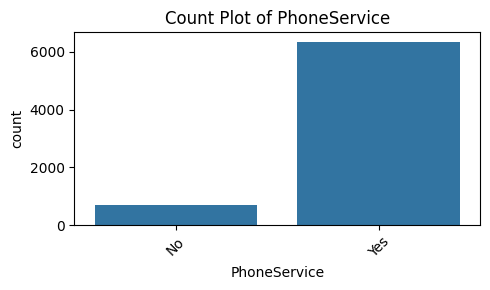

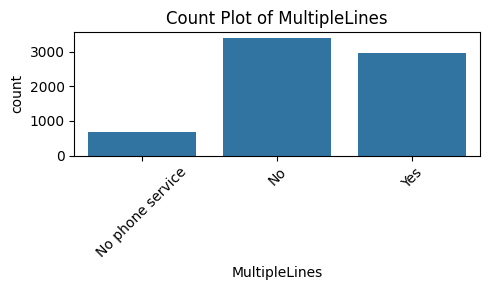

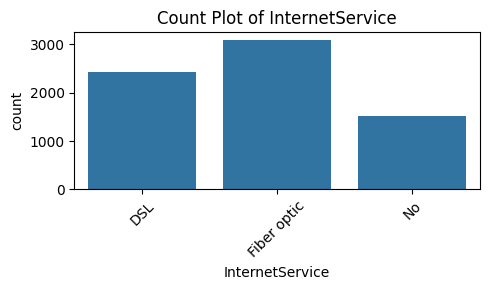

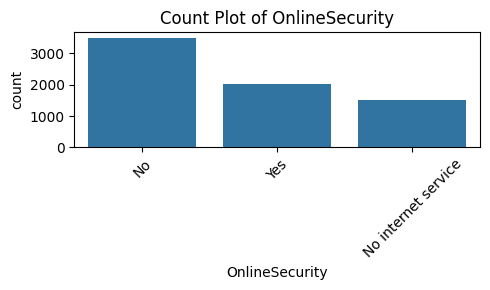

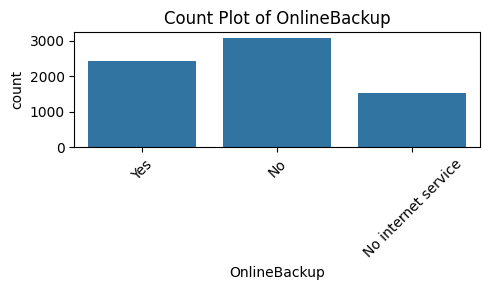

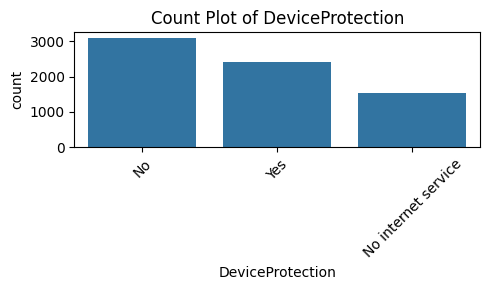

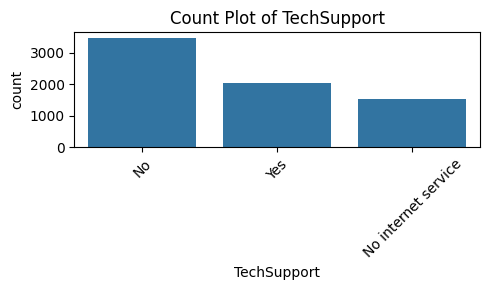

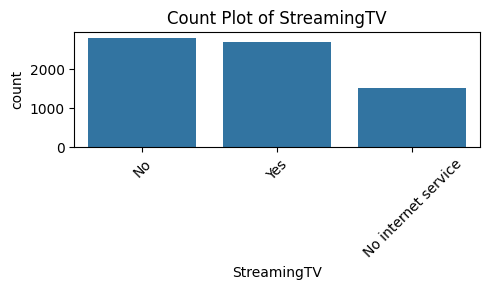

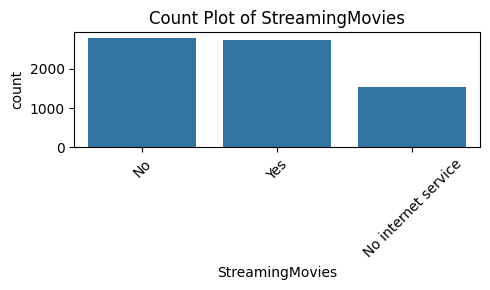

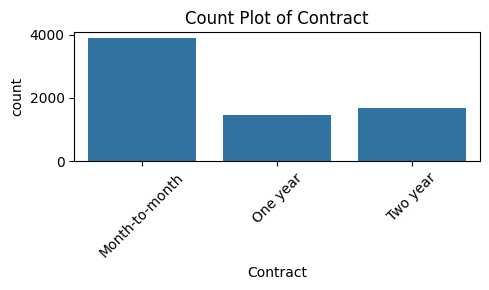

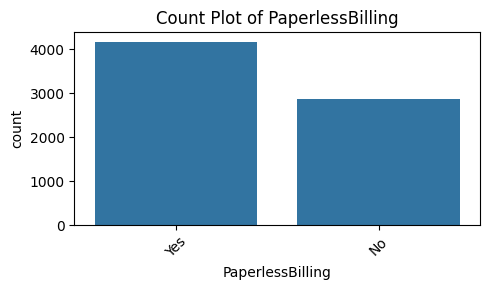

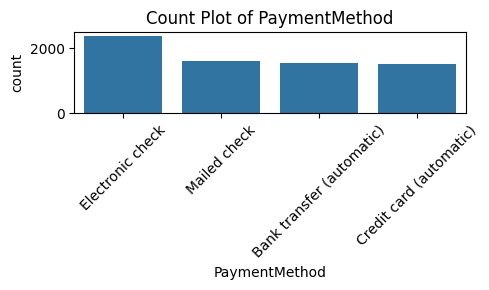

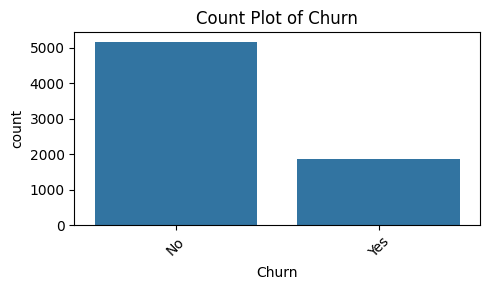

In [72]:
# EDA - Categorical Feature Count Plots
cat_features = df.select_dtypes(include='object').columns.tolist()
cat_features = ['SeniorCitizen'] + cat_features

for col in cat_features:
    plt.figure(figsize=(5, 3))
    sns.countplot(x=df[col])
    plt.title(f"Count Plot of {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [73]:
# Label Encode categorical features
object_columns = df.select_dtypes(include='object').columns
encoders = {}
for column in object_columns:
    encoder = LabelEncoder()
    df[column] = encoder.fit_transform(df[column])
    encoders[column] = encoder

In [74]:
# Save encoders
with open("encoders.pkl", "wb") as f:
    pickle.dump(encoders, f)

In [75]:
# Encode target
df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})

In [76]:
# Train-Test Split
X = df.drop(columns=['Churn'])
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [77]:
# Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
print(y_train_smote.value_counts())

After SMOTE:
Churn
0    4139
1    4139
Name: count, dtype: int64


In [78]:
# Model Training with Stratified K-Fold Cross Validation
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train_smote, y_train_smote, cv=cv, scoring='accuracy')
    cv_scores[name] = scores
    print(f"{name} Accuracy: {np.mean(scores):.4f}")

Decision Tree Accuracy: 0.7885
Random Forest Accuracy: 0.8488


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:45:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:45:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:45:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:45:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8477


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:45:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [79]:
# Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

best_model = grid_search.best_estimator_
print("Best Random Forest Params:", grid_search.best_params_)

Best Random Forest Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [80]:
# Evaluate on Test Data
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

Accuracy: 0.7799858055358411
Confusion Matrix:
 [[871 164]
 [146 228]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      1035
           1       0.58      0.61      0.60       374

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.72      1409
weighted avg       0.78      0.78      0.78      1409

ROC-AUC Score: 0.7255857810845023


In [81]:
# Save Model
model_data = {
    'model': best_model,
    'features_names': X.columns.tolist()
}

with open("customer_churn_model.pkl", "wb") as f:
    pickle.dump(model_data, f)

In [82]:
# Predictive System
input_data = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 1,
    'PhoneService': 'No',
    'MultipleLines': 'No phone service',
    'InternetService': 'DSL',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 29.85,
    'TotalCharges': 29.85
}

input_df = pd.DataFrame([input_data])

In [83]:
# Load encoders
with open("encoders.pkl", "rb") as f:
    encoders = pickle.load(f)

In [88]:
# Encode inputs
for col, encoder in encoders.items():
    if col in input_df.columns and input_df[col].dtype == 'object':
        input_df[col] = encoder.transform(input_df[col])
# Load model
with open("customer_churn_model.pkl", "rb") as f:
    model_data = pickle.load(f)

model = model_data['model']
pred = model.predict(input_df)[0]
prob = model.predict_proba(input_df)[0]

print(f"Prediction: {'Churn' if pred == 1 else 'No Churn'}")
print(f"Probability: {prob}")

Prediction: No Churn
Probability: [0.68381566 0.31618434]
